# RNN Eğitim Notebook
Bu Jupyter Notebook, hem NumPy tabanlı hem de PyTorch tabanlı RNN modellerini eğitir ve sonuçları gösterir.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## NumPy ile Basit RNN

In [2]:
# Örnek veri
np.random.seed(42)
vocab_size = 10
train_data = {tuple(np.random.randint(0, vocab_size, size=5)): np.random.choice([0,1]) for _ in range(100)}

In [3]:
class RNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.hidden_size = hidden_size
        self.W = np.random.randn(hidden_size, input_size) * 0.1
        self.U = np.random.randn(hidden_size, hidden_size) * 0.1
        self.V = np.random.randn(output_size, hidden_size) * 0.1
        self.b = np.zeros((hidden_size,1))
        self.c = np.zeros((output_size,1))
    def forward(self, inputs):
        h = np.zeros((self.hidden_size, 1))
        self.hs = [h]
        for x in inputs:
            x_vec = np.zeros((vocab_size,1)); x_vec[x,0]=1
            h = np.tanh(self.W @ x_vec + self.U @ h + self.b)
            self.hs.append(h)
        y = self.V @ h + self.c
        return y, self.hs
    def backward(self, inputs, ys, dy):
        dW=np.zeros_like(self.W); dU=np.zeros_like(self.U)
        dV=np.zeros_like(self.V); db=np.zeros_like(self.b); dc=np.zeros_like(self.c)
        dh_next=np.zeros((self.hidden_size,1))
        dV+=dy @ ys[-1].T; dc+=dy
        for t in reversed(range(len(inputs))):
            dh = self.V.T @ dy + dh_next
            h = ys[t+1]
            dh_raw = (1 - h*h) * dh
            db += dh_raw
            x_vec = np.zeros((vocab_size,1)); x_vec[inputs[t],0]=1
            dW += dh_raw @ x_vec.T
            dU += dh_raw @ ys[t].T
            dh_next = self.U.T @ dh_raw
        return dW, dU, dV, db, dc
    def update(self, grads, lr):
        for param, grad in zip([self.W,self.U,self.V,self.b,self.c], grads):
            param -= lr * grad
def softmax(x):
    e = np.exp(x - np.max(x)); return e / e.sum()

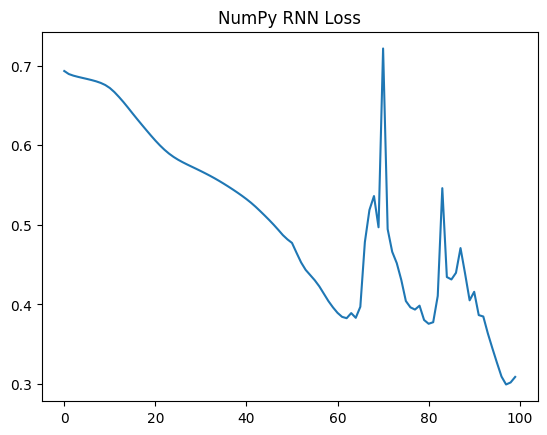

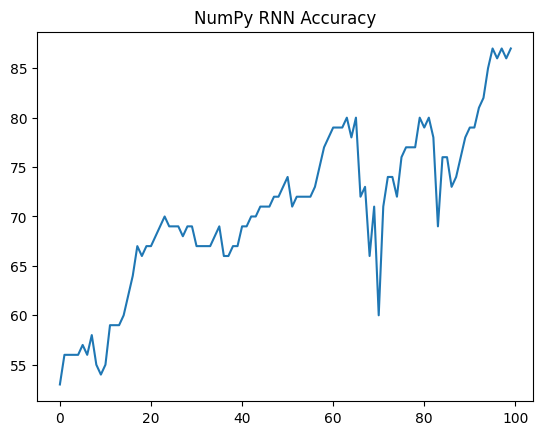

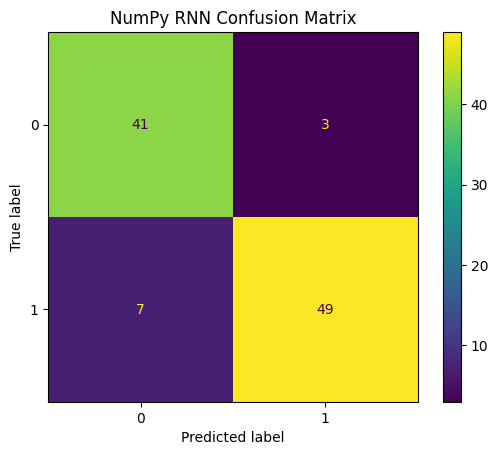

NumPy RNN Final Accuracy: 87.00%


In [4]:
# Eğitim NumPy RNN
rnn = RNN(input_size=vocab_size, hidden_size=16, output_size=2)
epochs, lr = 100, 0.01
loss_hist, acc_hist = [], []
for epoch in range(1, epochs+1):
    total_loss, correct = 0, 0
    for inputs, label in train_data.items():
        y, hs = rnn.forward(inputs)
        p = softmax(y)
        total_loss += -np.log(p[label,0])
        pred = np.argmax(p)
        correct += int(pred==label)
        dy = p.copy(); dy[label,0]-=1
        grads = rnn.backward(inputs, hs, dy)
        rnn.update(grads, lr)
    loss_hist.append(total_loss/len(train_data))
    acc_hist.append(correct/len(train_data)*100)
# Grafikler
plt.figure(); plt.plot(loss_hist); plt.title('NumPy RNN Loss'); plt.show()
plt.figure(); plt.plot(acc_hist); plt.title('NumPy RNN Accuracy'); plt.show()
# Confusion Matrix
y_true, y_pred = [], []
for inputs,label in train_data.items():
    y,_=rnn.forward(inputs); pred=np.argmax(softmax(y))
    y_true.append(label); y_pred.append(pred)
cm=confusion_matrix(y_true,y_pred)
ConfusionMatrixDisplay(cm).plot(); plt.title('NumPy RNN Confusion Matrix'); plt.show()
print(f"NumPy RNN Final Accuracy: {acc_hist[-1]:.2f}%")

## PyTorch ile RNN

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
# Veri hazırlama torch tensorler halinde
sequences = list(train_data.keys())
labels = list(train_data.values())
X = torch.tensor(sequences, dtype=torch.long)  # shape (100,5)
y = torch.tensor(labels, dtype=torch.long)     # shape (100,)

In [7]:
class TorchRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, vocab_size)  
        self.rnn = nn.RNN(input_size=vocab_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x_one = self.embedding(x)  
        out, _ = self.rnn(x_one)
        out = out[:,-1,:]
        return self.fc(out)

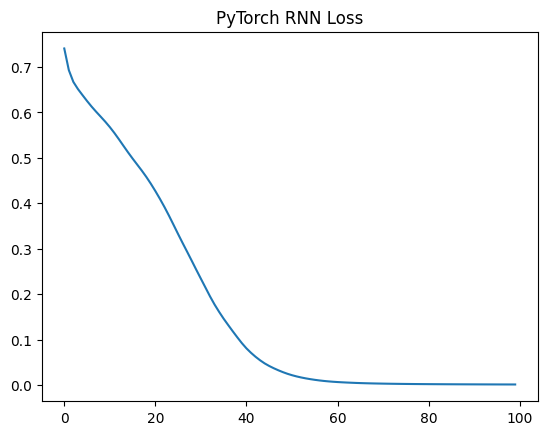

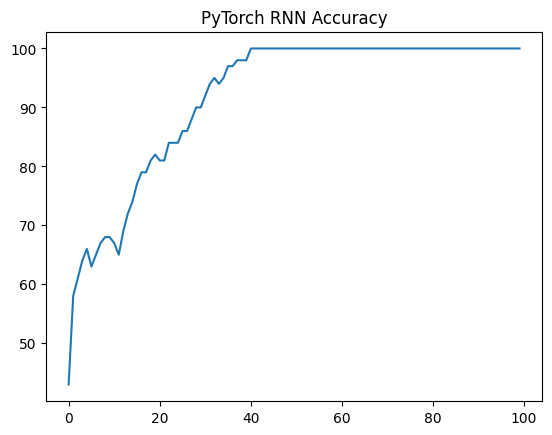

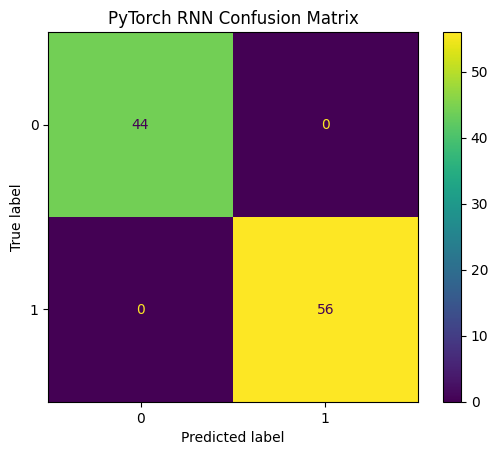

PyTorch RNN Final Accuracy: 100.00%


In [8]:
# Eğitim PyTorch RNN
model = TorchRNN(vocab_size, hidden_size=16, output_size=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 100
losses_pt, accs_pt = [], []
for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    losses_pt.append(loss.item())
    pred = outputs.argmax(dim=1)
    accs_pt.append((pred==y).float().mean().item()*100)
# Grafikler
plt.figure(); plt.plot(losses_pt); plt.title('PyTorch RNN Loss'); plt.show()
plt.figure(); plt.plot(accs_pt); plt.title('PyTorch RNN Accuracy'); plt.show()
# Confusion Matrix PyTorch
with torch.no_grad():
    preds = model(X).argmax(dim=1).numpy()
cm_pt = confusion_matrix(labels, preds)
ConfusionMatrixDisplay(cm_pt).plot(); plt.title('PyTorch RNN Confusion Matrix'); plt.show()
print(f"PyTorch RNN Final Accuracy: {accs_pt[-1]:.2f}%")